In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from IPython.display import display, Image

/jet/var/python/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

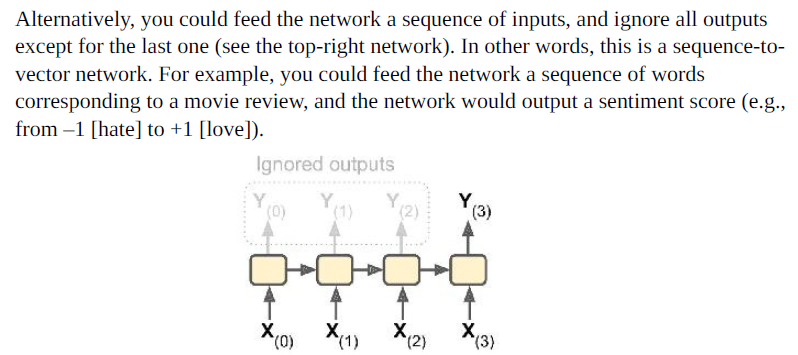

In [8]:
# The RNN type we will use here is following
Image('10.PNG')

each 28×28-pixel image can be
viewed as a sequence of length 28, each element in the sequence a vector of 28 pixels

## Example below base on Book O`REILLY  "Learning Tensorflow", p. 82

In [9]:
element_size = 28 #  dimension of each vector in our sequence
time_steps = 28   #  number of such elements in a sequence
num_classes = 10
batch_size = 128
hidden_layer_size = 128

_inputs = tf.placeholder(tf.float32,shape=[None, time_steps, element_size], name='inputs')
y = tf.placeholder(tf.float32, shape=[None, num_classes],name='inputs')
# TensorFlow built-in functions
rnn_cell = tf.contrib.rnn.BasicRNNCell(hidden_layer_size)
outputs, _ = tf.nn.dynamic_rnn(rnn_cell, _inputs, dtype=tf.float32)
Wl = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes],
mean=0,stddev=.01))
bl = tf.Variable(tf.truncated_normal([num_classes],mean=0,stddev=.01))
def get_linear_layer(vector):
    return tf.matmul(vector, Wl) + bl

last_rnn_output = outputs[:,-1,:]
final_output = get_linear_layer(last_rnn_output)
softmax = tf.nn.softmax_cross_entropy_with_logits(logits=final_output,
labels=y)
cross_entropy = tf.reduce_mean(softmax)
train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(final_output,1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#test_data = mnist.test.images[:batch_size].reshape((-1, time_steps, element_size))
#test_label = mnist.test.labels[:batch_size]

for i in range(1001):
    offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
    batch_x, batch_y = train_dataset[offset:(offset+batch_size),:], train_labels[offset:(offset+batch_size)]
    batch_x = batch_x.reshape((batch_size, time_steps, element_size))
    sess.run(train_step,feed_dict={_inputs:batch_x, y:batch_y})
    if i % 1000 == 0:
        acc = sess.run(accuracy, feed_dict={_inputs: batch_x, y: batch_y})
        loss = sess.run(cross_entropy,feed_dict={_inputs:batch_x, y:batch_y})
        print ("Iter " + str(i) + ", Minibatch Loss= " + \
            "{:.6f}".format(loss) + ", Training Accuracy= " + \
                "{:.5f}".format(acc))

#print ("Testing Accuracy:",sess.run(accuracy, feed_dict={_inputs: test_dataset, y: test_labels}))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Iter 0, Minibatch Loss= 2.309543, Training Accuracy= 9.37500
Iter 1000, Minibatch Loss= 0.519639, Training Accuracy= 85.15625


In [10]:
print ("Testing Accuracy:",sess.run(accuracy, feed_dict={_inputs: test_dataset.reshape((test_labels.shape[0], time_steps, element_size)), y: test_labels}))

Testing Accuracy: 88.15


In [19]:
element_size = 28 #  dimension of each vector in our sequence
time_steps = 28   #  number of such elements in a sequence
num_classes = 10
batch_size = 128
hidden_layer_size = 128 # neurons number
n_epochs = 100
learning_rate = 0.001

graph = tf.Graph()
with graph.as_default():
    _inputs = tf.placeholder(tf.float32,shape=[None, time_steps, element_size])
    y = tf.placeholder(tf.float32, shape=[None,num_classes])
    # TensorFlow built-in functions
    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden_layer_size)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, _inputs, dtype=tf.float32)   # outputs a single tensor for all outputs at every time step
    Wl = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes],
    mean=0,stddev=.01))
    bl = tf.Variable(tf.truncated_normal([num_classes],mean=0,stddev=.01))
    def get_linear_layer(vector):
        return tf.matmul(vector, Wl) + bl
    last_rnn_output = outputs[:,-1,:]
    final_output = get_linear_layer(last_rnn_output)
    softmax = tf.nn.softmax_cross_entropy_with_logits(logits=final_output,
    labels=y)
    cross_entropy = tf.reduce_mean(softmax)
    train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(final_output,1))
    accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

In [20]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for i in range(1001):
        offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
        batch_x, batch_y = train_dataset[offset:(offset+batch_size),:], train_labels[offset:(offset+batch_size)]
        batch_x = batch_x.reshape((batch_size, time_steps, element_size))
        #acc = sess.run(accuracy, feed_dict={_inputs: batch_x, y: batch_y})
        #loss = sess.run(cross_entropy,feed_dict={_inputs:batch_x, y:batch_y})
        sess.run(train_step,feed_dict={_inputs:batch_x, y:batch_y})
        if i % 1000 == 0:
            acc = sess.run(accuracy, feed_dict={_inputs: batch_x, y: batch_y})
            loss = sess.run(cross_entropy,feed_dict={_inputs:batch_x, y:batch_y})
            print ("Iter " + str(i) + ", Minibatch Loss= " + \
                "{:.6f}".format(loss) + ", Training Accuracy= " + \
                    "{:.5f}".format(acc))
            print ("Testing Accuracy:",sess.run(accuracy, feed_dict={_inputs: test_dataset.reshape((test_labels.shape[0], time_steps, element_size)), y: test_labels}))
        #print(sess.run(final_output, feed_dict={_inputs: valid_dataset.reshape((valid_labels.shape[0], time_steps, element_size))}))
    print ("Validation Accuracy:",sess.run(accuracy, feed_dict={_inputs: valid_dataset.reshape((valid_labels.shape[0], time_steps, element_size)), y: valid_labels}))    

Initialized
Iter 0, Minibatch Loss= 2.297944, Training Accuracy= 16.40625
Testing Accuracy: 13.38
Iter 1000, Minibatch Loss= 0.465857, Training Accuracy= 85.93750
Testing Accuracy: 88.62
Validation Accuracy: 82.48


## The method from book O`REILLY ' Hands-On Machine Learning with Scikit-Learn & Tensorflow" (the results are almost same)

In [26]:
element_size = 28 #  dimension of each vector in our sequence
time_steps = 28   #  number of such elements in a sequence
num_classes = 10
batch_size = 128
hidden_layer_size = 128 # neurons number
n_epochs = 100
learning_rate = 0.001

graph = tf.Graph()
with graph.as_default():
    _inputs = tf.placeholder(tf.float32,shape=[None, time_steps, element_size])
    y = tf.placeholder(tf.float32, shape=[None,num_classes])
    # TensorFlow built-in functions
    rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden_layer_size)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, _inputs, dtype=tf.float32)   # outputs a single tensor for all outputs at every time step
    logits = tf.layers.dense(states, n_outputs)
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits ,labels=y)
    loss = tf.reduce_mean(xentropy)
    #optimizer = tf.train.RMSPropOptimizer(0.001, 0.9)
    training_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(loss)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))*100

In [27]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for i in range(1001):
        offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
        batch_x, batch_y = train_dataset[offset:(offset+batch_size),:], train_labels[offset:(offset+batch_size)]
        batch_x = batch_x.reshape((batch_size, time_steps, element_size))
        #acc = sess.run(accuracy, feed_dict={_inputs: batch_x, y: batch_y})
        #loss = sess.run(cross_entropy,feed_dict={_inputs:batch_x, y:batch_y})
        sess.run(training_op,feed_dict={_inputs:batch_x, y:batch_y})
        if i % 1000 == 0:
            acc = sess.run(accuracy, feed_dict={_inputs: batch_x, y: batch_y})
            loss_train = sess.run(loss,feed_dict={_inputs:batch_x, y:batch_y})
            print ("Iter " + str(i) + ", Minibatch Loss= " + \
                "{:.6f}".format(loss_train) + ", Training Accuracy= " + \
                    "{:.5f}".format(acc))
            print ("Testing Accuracy:",sess.run(accuracy, feed_dict={_inputs: test_dataset.reshape((test_labels.shape[0], time_steps, element_size)), y: test_labels}))
        #print(sess.run(final_output, feed_dict={_inputs: valid_dataset.reshape((valid_labels.shape[0], time_steps, element_size))}))
    print ("Validation Accuracy:",sess.run(accuracy, feed_dict={_inputs: valid_dataset.reshape((valid_labels.shape[0], time_steps, element_size)), y: valid_labels}))    

Initialized
Iter 0, Minibatch Loss= 2.443900, Training Accuracy= 7.81250
Testing Accuracy: 6.99
Iter 1000, Minibatch Loss= 0.548196, Training Accuracy= 82.03125
Testing Accuracy: 88.93
Validation Accuracy: 82.83


## RNN Learning

Firstly lets create a simple RNN without special command

In [20]:
n_inputs = 3
n_neurons = 5
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [21]:
# Mini-batch: instance 0,instance 1,instance 2,instance 3
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

In [22]:
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [23]:
print(Y0_val) # output at t = 0

[[-0.9999887  -0.18642476  0.9761181   0.7520412   0.9692784 ]
 [-1.         -0.9972914  -0.9911525   0.9993227   0.99993116]
 [-1.         -0.99999464 -0.99999964  0.9999984   1.        ]
 [ 0.999738   -1.         -1.          0.91238     0.9874672 ]]


In [24]:
print(Y1_val) # output at t = 1

[[-1.         -1.         -1.          1.          0.99999195]
 [-0.5800535  -0.9790267  -0.71333945  0.9458815   0.7870579 ]
 [-1.         -0.99999976 -1.          0.99999785  0.9999271 ]
 [-0.9998254  -0.9827366  -0.9999998  -0.89915955  0.98829347]]


The static_rnn() function creates an unrolled RNN network by chaining cells. The
following code creates the exact same model as the previous one:

In [25]:
n_inputs
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

The dynamic_rnn() function uses a while_loop() operation to run over the cell the appropriate number of times, and you can set swap_memory=True if you want it to swap the GPU’s memory to the CPU’s memory during backpropagation to avoid OOM errors.
Conveniently, it also accepts a single tensor for all inputs at every time step (shape [None, n_steps, n_inputs]) and it outputs a single tensor for all outputs at every time step (shape [None, n_steps, n_neurons]); there is no need to stack, unstack, or transpose. The following code creates the same RNN as earlier using the dynamic_rnn() function.

In [11]:
# X_batch is a single tensor that contains all the mini-batch sequences
X_batch = np.array([
# t = 0       t = 1
[[0, 1, 2], [9, 8, 7]], # instance 0
[[3, 4, 5], [0, 0, 0]], # instance 1
[[6, 7, 8], [6, 5, 4]], # instance 2
[[9, 0, 1], [3, 2, 1]], # instance 3
])
_, n_steps, n_inputs = X_batch.shape
n_neurons = 28
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [15]:
X_batch.shape

(4, 2, 3)

In [13]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [16]:
outputs_val.shape

(4, 2, 28)

In [14]:
print(outputs_val)

[[[-0.6577649  -0.03103606  0.45485848 -0.21327238 -0.6515705
   -0.13881283 -0.02527059  0.28419888  0.41501588  0.65372276
   -0.5926774   0.09182104  0.2026018   0.01785902  0.42064646
   -0.16497089  0.40700018  0.03159994  0.54728377  0.03624927
   -0.27569377 -0.44964752 -0.23813048 -0.49611682 -0.3710978
    0.265787   -0.38279623  0.25080666]
  [-0.9945605   0.9268842  -0.8821548  -0.9753277  -0.9995841
   -0.9806254   0.99963427 -0.83623576 -0.7197569   0.9999847
   -0.99998844 -0.99641323  0.99299645  0.2138974   0.3361428
    0.9809474   0.28722632 -0.9427363   0.9309016   0.03960767
   -0.9988027  -0.9708954  -0.99801564 -0.74364275  0.8576674
   -0.98397493 -0.9439201   0.89080423]]

 [[-0.9635135   0.46165004  0.32692462 -0.7729235  -0.9854051
   -0.7427962   0.80558306 -0.14742957  0.3414066   0.995141
   -0.9917317  -0.7469071   0.8362765   0.3205945   0.6780916
    0.4382115   0.5071329  -0.473678    0.82505685 -0.03689764
   -0.9365758  -0.8556075  -0.9117399  -0.7424